# High Value Customer Identification (Insiders)

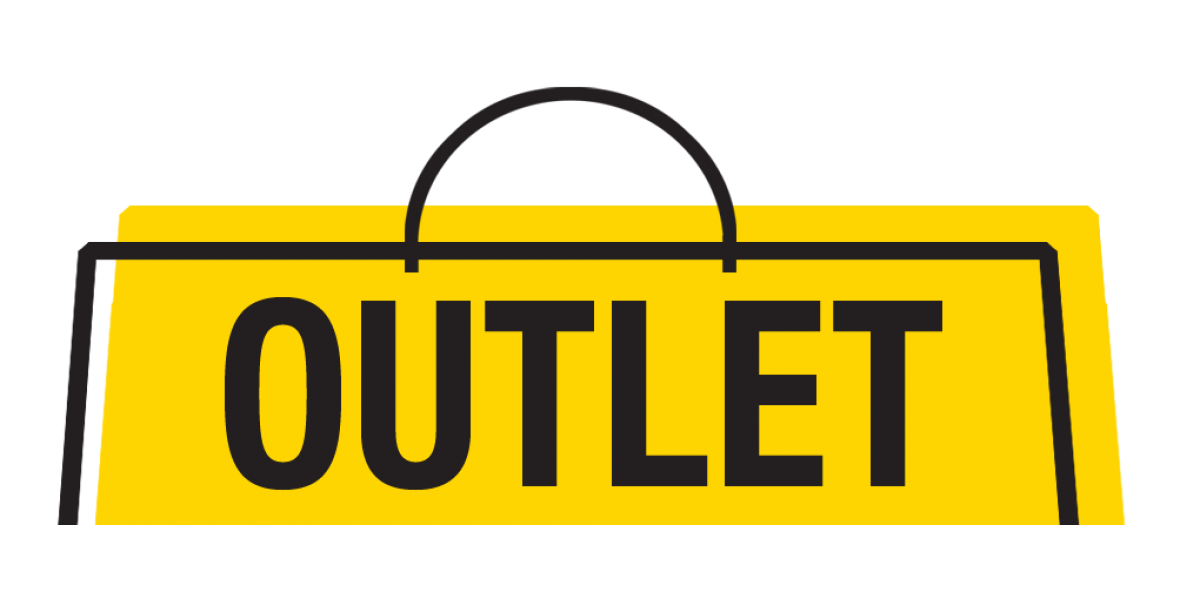

The company All in One Place is a Multibrand Outlet company, i.e., it sells second line products of various brands at a lower price, through an e-commerce platform. In 1 year of operation, the marketing team realized that some customers in its base buy more expensive products with high frequency and end up contributing with a significant portion of the company's revenue. Based on this perception, the marketing team will launch a loyalty program for the best customers in the base, called Insiders. But the team does not have an advanced knowledge of data analysis to choose the program participants. For this reason, the marketing team asked the data team to select eligible customers for the program, using advanced data manipulation techniques.

**Table of contents**

* 0.0. [Imports](#imports)

# Solution Planning (IOT) <a id='solution_planning'></a>

## Input <a id='input'></a>

1. Business Problem
    * Select most valuable customers to join a loyalty program.
2. Dataset
    * E-commerce online sales, for 1 year.

## Output  <a id='output'></a>

1. List of customers who will join the Insiders program.
    * List:
    | client_id | is_insider |
    | ---  | --- |
    | 10323 | yes/1 |
    | 10323 | no/0 |
    
2. Aswer business questions

    1. Who are the people eligible to join the Insiders program?
    2. How many customers will be part of the group?
    3. What are the main characteristics of these customers?
    4. What is the percentage of revenue contribution coming from the Insiders?
    5. What is the expected revenue of this group for the next months?
    6. What are the conditions for a person to be eligible to join Insiders?
    7. How can a person be removed from the Insiders program?
    8. What is the guarantee that the Insiders program is better than the rest of the base ?
    9. What actions can the marketing team take to increase revenue?

## Tasks <a id='tasks'></a>

**1. Who are the people eligible to join the Insiders program?**

* What is being eligible? What are most valuable customers?
* Revenue:
    * High average ticket
    * High LTV (Life Time Value)
    * Low Recency (Las time of purcharse)
    * Big basket size
    * Low churn probability
    * High LTV Prediction
    * High propensity to buy
* Cost:
    * Low return rate
* Shopping experience:
    * High average evaluation

**2. How many customers will be part of the group?**

* Total number of customers
* % of Insiders Group

**3. What are the main characteristics of these customers?**

* Get some customer's characteristics
    * Age
    * Localization

* Get consumption characteristics
    * Clustering attributes

**4. What is the percentage of revenue contribution coming from the Insiders?**

* Anual total revenue
* Insiders' revenue

**5. What is the expected revenue of this group for the next months?**

* Insiders' LTV
* Cohort Analysis

**6. What are the conditions for a person to be eligible to join Insiders?**

* Define model periodicity (1, 3 months)
* The person should be similar to the selected customers.

**7. How can a person be removed from the Insiders program?**

* Define model periodicity (1, 3 months)
* The person should be different to the selected customers.

**8. What is the guarantee that the Insiders program is better than the rest of the base ?**

* Hypothesis Testing
* A/B Testing
* A/B Bayesian Testing

**9. What actions can the marketing team take to increase revenue?**

* Discount
* Purcharse preference
* Shipping
* Company visit

## Solution Benchmark <a id='solution_benchmark'></a>

* RFM Score

<img src="./img/rfm.png" alt="RFM" style="width: 600px;"/>

# 0.0. Imports <a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from umap.umap_ import UMAP

from IPython.display import HTML

init_notebook_mode(connected=True)

D:\Anaconda\envs\py385\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 0.1. Helper Functions <a id='helper_functions'></a>

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

In [3]:
jupyter_settings()

## 0.1. Load dataset <a id='load_dataset'></a>

In [4]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw.drop(df_raw.columns[len(df_raw.columns)-1], axis=1, inplace=True)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Data Description <a id='data_description'></a>

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns <a id='rename_columns'></a>

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions <a id='data_dimensions'></a>

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types <a id='data_types'></a>

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check Missing Values <a id='check_na'></a>

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill Missing Values <a id='fill_na'></a>

In [11]:
# remove NA values
df1.dropna(subset = ['description', 'customer_id'], inplace = True)
print('Removed data: {:.2f}'.format( (1 - df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change DTypes <a id='change_dtypes'></a>

In [13]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Descriptive Statistical <a id='descriptive_statistical'></a>

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes <a id='numerical_attributes'></a>

In [16]:
num = num_attributes.describe().T
num['skew'] = num_attributes.apply(lambda x: x.skew())
num['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0,0.182663,94317.563673
unit_price,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0,452.219019,246924.542988


**Investigate**
1. Negative quantity
2. Min unit_price equal 0

### 1.7.2. Categorical Attributes <a id='categorical_attributes'></a>

#### Invoice No

In [17]:
cat_attributes.head()

,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,United Kingdom


In [18]:
# number of invoice_no that has letters inside it
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(f'Number of distinct invoice_no that has letter in it: {len(df_letter_invoices.invoice_no.unique())}')
print(f'Number of total invoice_no that has letter in it: {len(df_letter_invoices)}')
n = len(df_letter_invoices.loc[df_letter_invoices['quantity'] < 0])
print(f'Number of invoice_no that has letter in it and quantity is less than 0: {n}')
df_letter_invoices.head()

Number of distinct invoice_no that has letter in it: 3654
Number of total invoice_no that has letter in it: 8872
Number of invoice_no that has letter in it and quantity is less than 0: 8872


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


**To do:**

* Use negative values in feature engineering

#### Stock Code

In [19]:
# number of stock_code that has letters inside it
aux = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

886


,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,United Kingdom
45,536370,POST,POSTAGE,12583,France


In [20]:
# number of stock_code that has ONLY letters inside it
aux = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

6


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom


In [21]:
# distinct stock_code with only letters
aux['stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

**To do:**

* Remove stock_code in: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

#### Description

**To do:**

* Remove Description

#### Country

In [22]:
# countries in dataset
len(df1['country'].unique())

37

In [23]:
# check purchase's volumetry
df1['country'].value_counts(normalize = True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2.0. Data Filtering <a id='data_filtering'></a>

In [25]:
df2 = df1.copy()

In [26]:
df2.loc[df2['unit_price'] > 0.001, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)

,customer_id,description,unit_price
108088,16422,Discount,0.01
355050,16422,Manual,0.03
4287,15838,ROTATING SILVER ANGELS T-LIGHT HLDR,0.03
182729,12901,Discount,0.03
290431,14535,POPART WOODEN PENCILS ASST,0.04
228959,14282,POPART WOODEN PENCILS ASST,0.04
229052,14321,POPART WOODEN PENCILS ASST,0.04
286813,16607,POPART WOODEN PENCILS ASST,0.04
400404,12475,POPART WOODEN PENCILS ASST,0.04
307419,14572,POPART WOODEN PENCILS ASST,0.04


In [27]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# country
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

# description
df2.drop(columns = 'description', inplace = True)

# quantity - Negative numbers means devolution
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchases = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0. Feature Engineering <a id='feature_engineering'></a>

In [28]:
df3 = df2.copy()

## 2.1. Feature Creation <a id='feature_creation'></a>

In [29]:
# data reference
df_ref = df3.drop(columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']) \
            .drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [30]:
# Gross Revenue = quantity * price
df2_purchases['gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

In [31]:
# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [32]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = df_ref.merge(df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [33]:
# Frequency
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [34]:
# Avg Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue' : 'avg_ticket'})
df_ref = df_ref.merge(df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [35]:
# Number of returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no' : 'returns'})
df_ref = df_ref.merge(df_returns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [36]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


# 4.0. EDA (Exploratory Data Analysis) <a id='eda'></a>

In [37]:
df4 = df_ref.dropna().copy()

# 5.0. Data Preparation <a id='data_preparation'></a>

In [38]:
df5 = df4.copy()

In [39]:
mms = MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['invoice_no'] = mms.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
df5['returns'] = mms.fit_transform(df5[['returns']])

# 6.0. Feature Selection <a id='feature_selection'></a>

In [40]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning <a id='hyperparameter'></a>

In [41]:
X = df6.drop(columns = 'customer_id')

In [42]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square <a id='within_cluster'></a>

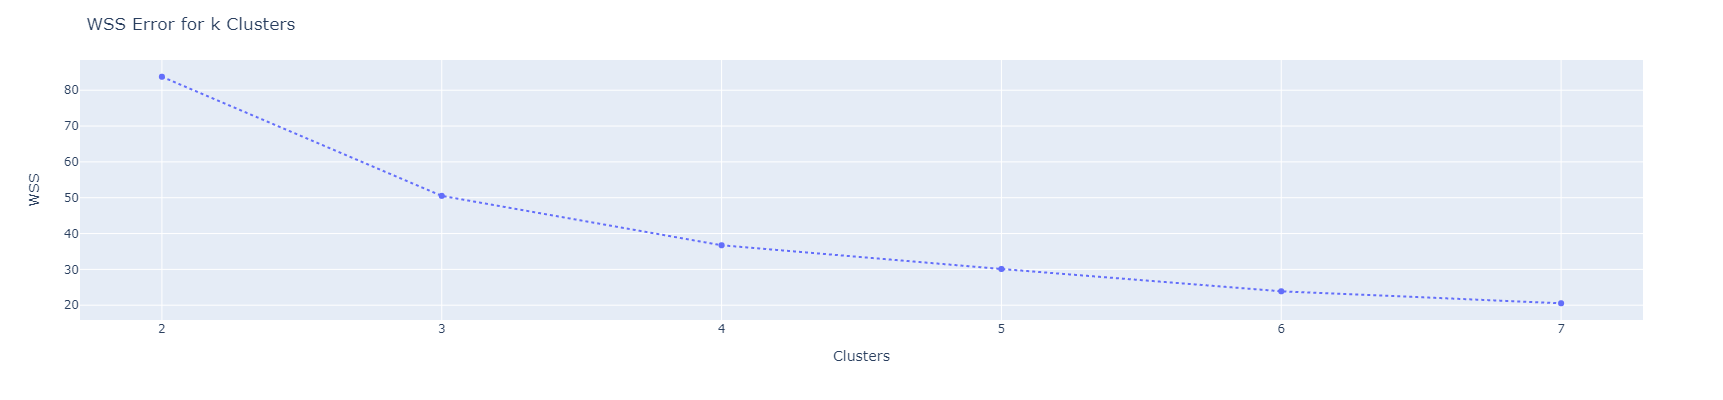

In [43]:
wss = []

for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method
fig = px.line(x=clusters, y=wss, markers = True, width=1200, height=400)
fig.update_layout(title='WSS Error for k Clusters',
                  xaxis_title="Clusters",
                  yaxis_title="WSS")
fig.update_traces(patch={"line": {"dash": 'dot'}}) 
fig.show()

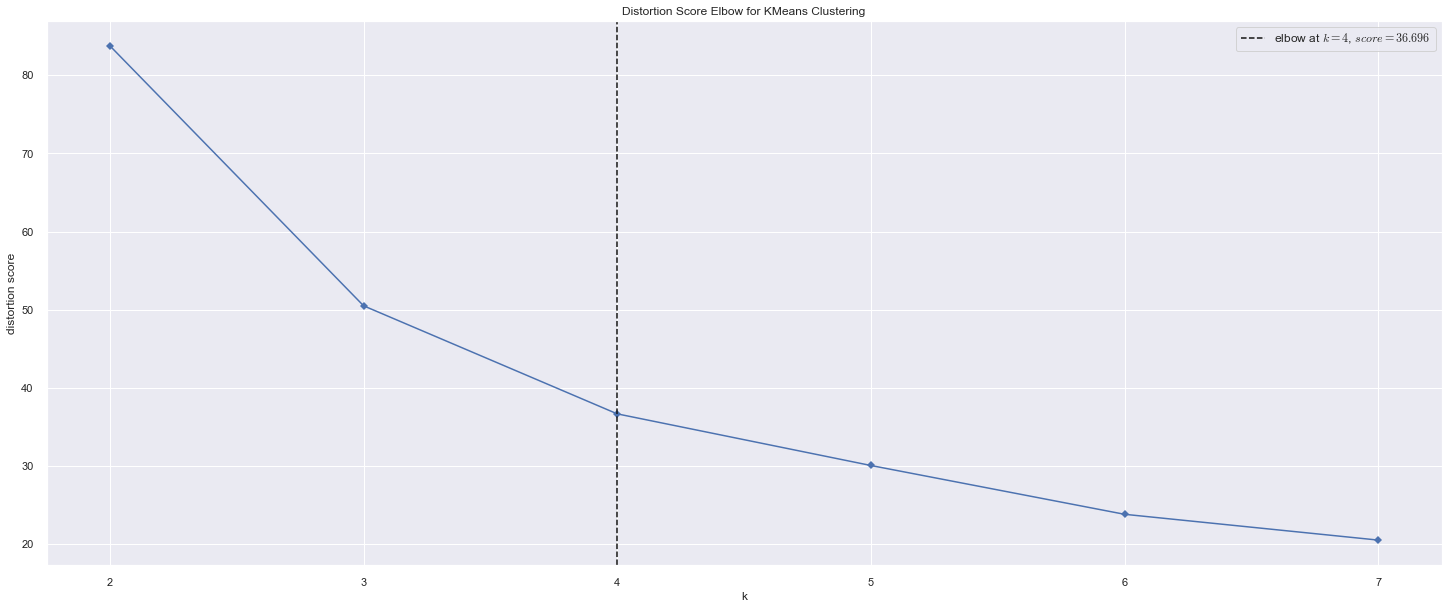

In [44]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings = False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score <a id='sillhouette_score'></a>

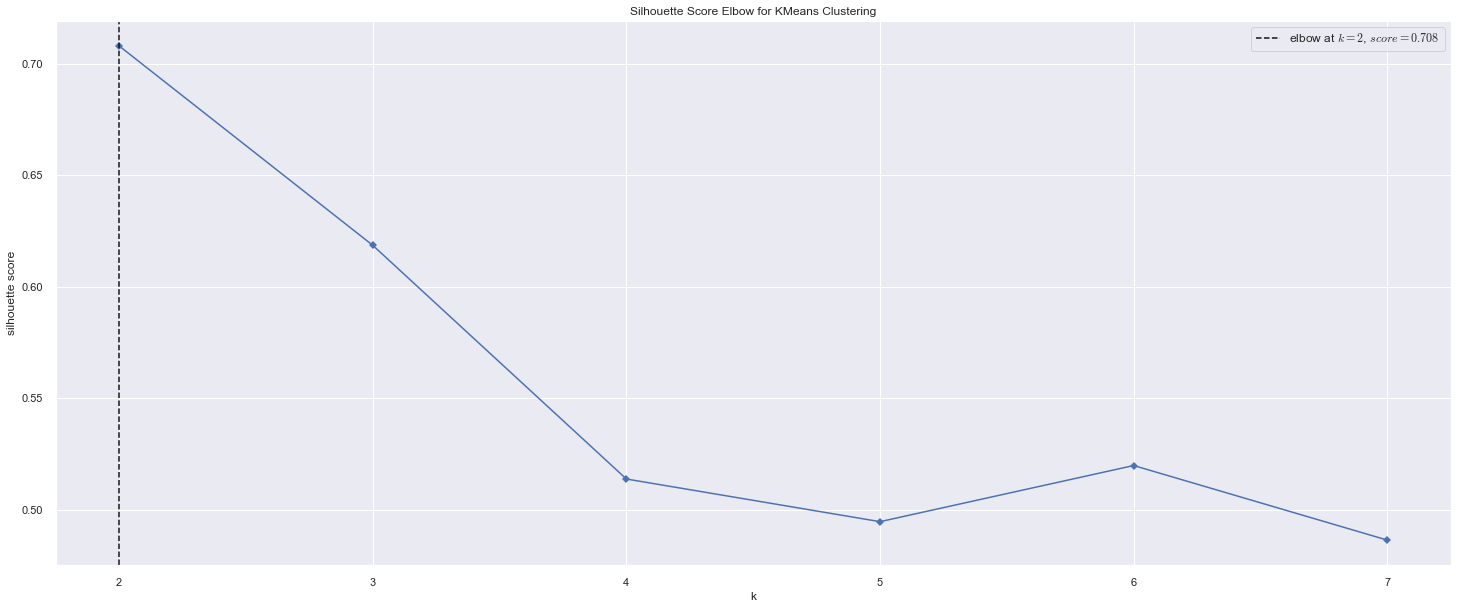

In [45]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric = 'silhouette', timings = False)
kmeans.fit(X)
kmeans.show();

## 7.3. Silhouette Analysis  <a id='sillhouette_analysis'></a>

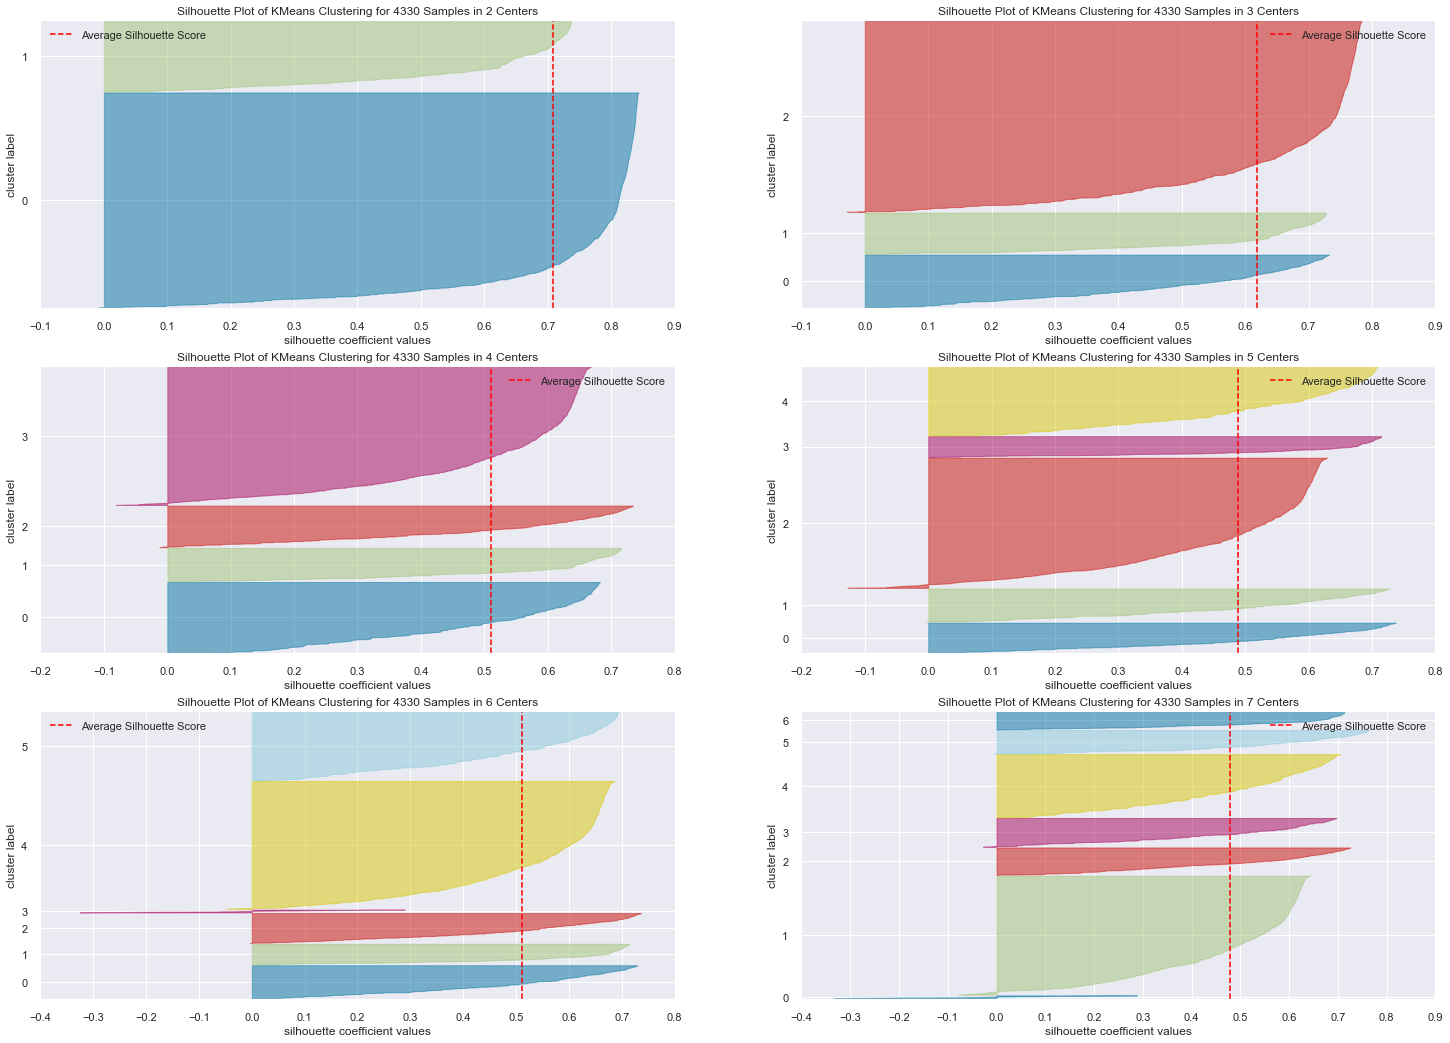

In [46]:
fig, ax = plt.subplots(3, 2, figsize = (25, 18))
for k in clusters:
    km = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 100, random_state = 42)
    visualizer = SilhouetteVisualizer(km, colors= 'yellowbrick', ax = ax.ravel()[k - min(clusters)])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0. Model Training <a id='model_training'></a>

## 8.1. K-Means <a id='kmeans'></a>

In [47]:
# model definition
k = 5
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation <a id='cluster_validation'></a>

In [48]:
# WSS (Within-cluster sum of squares)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS Value: {silhouette_score(X, labels, metric = "euclidean")}')

WSS Value: 30.106285672514545
SS Value: 0.48929546329828044


# 9.0. Cluster Analysis <a id='cluster_analysis'></a>

In [49]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222,3
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556,4
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444,2
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,4
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667,3


## 9.1. Visualization Inspection <a id='visualization_inspection'></a>

In [50]:
# fig = px.scatter_3d(df9, x = 'recency_days', y = 'invoice_no', z = 'gross_revenue', color = 'cluster')
# fig.show()

D:\Anaconda\envs\py385\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



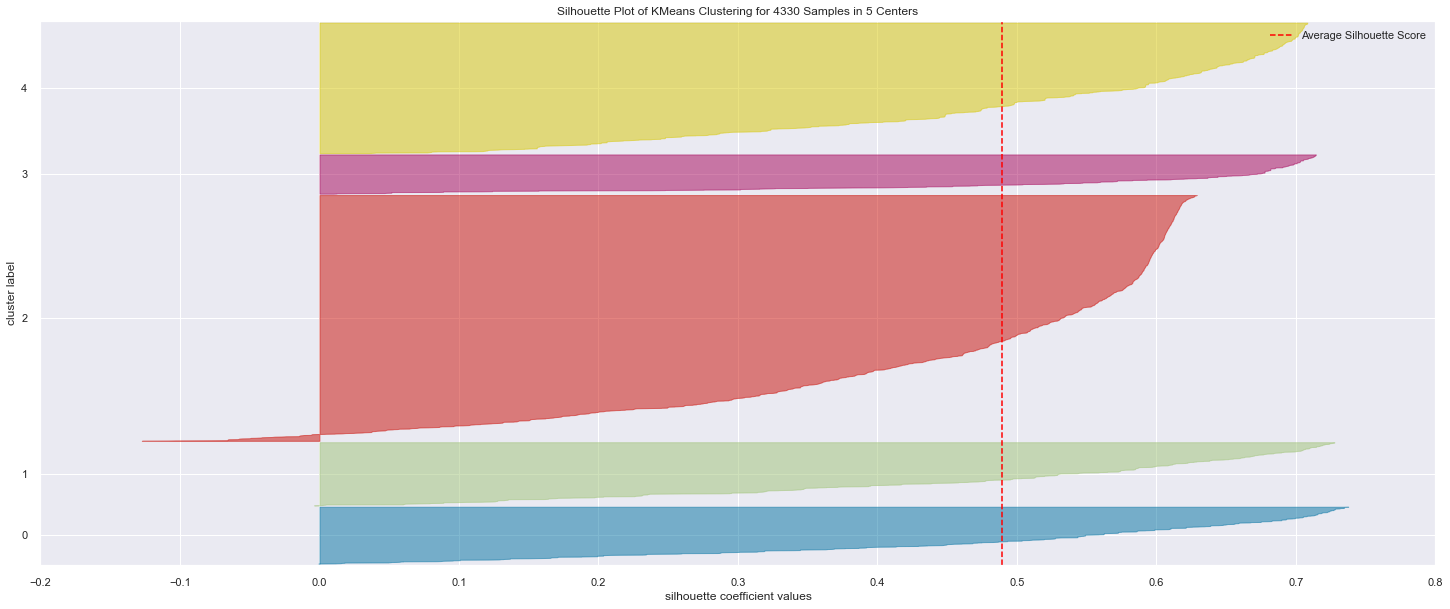

In [51]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2D Plot <a id='2d_plot'></a>

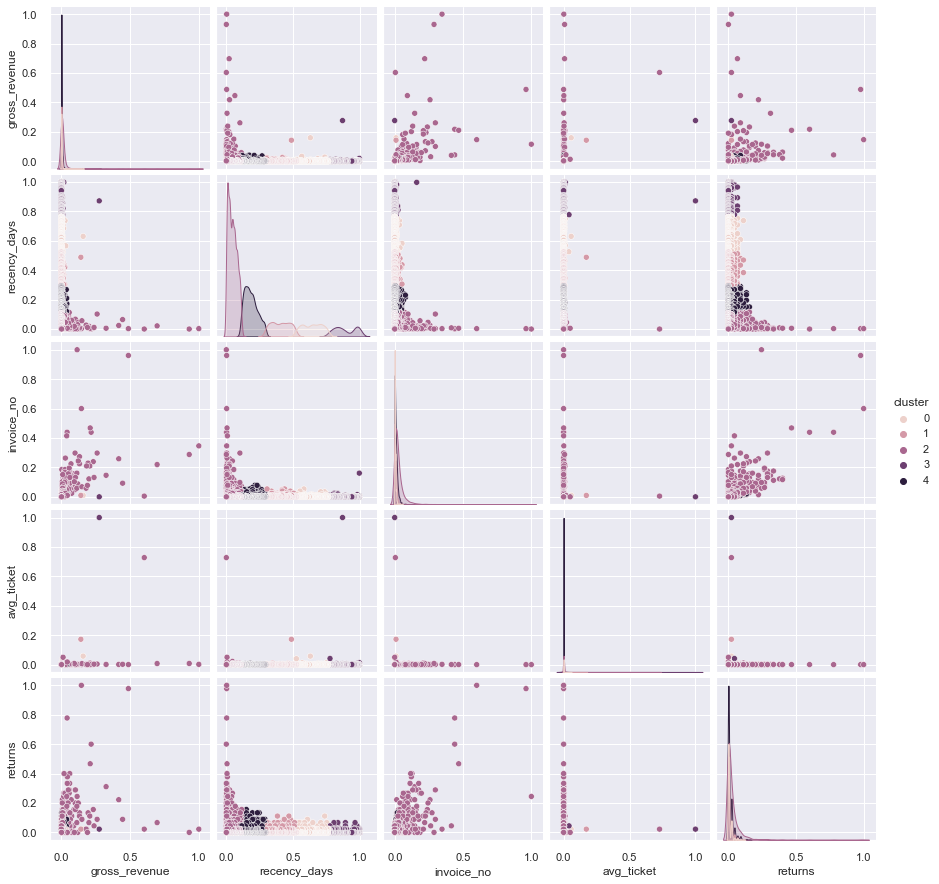

In [52]:
df_viz = df9.drop(columns = 'customer_id')
sns.pairplot(df_viz, hue = 'cluster');

## 9.3. UMAP <a id='umap'></a>

UMAP, t-SNE (2009): Manifold - Topology

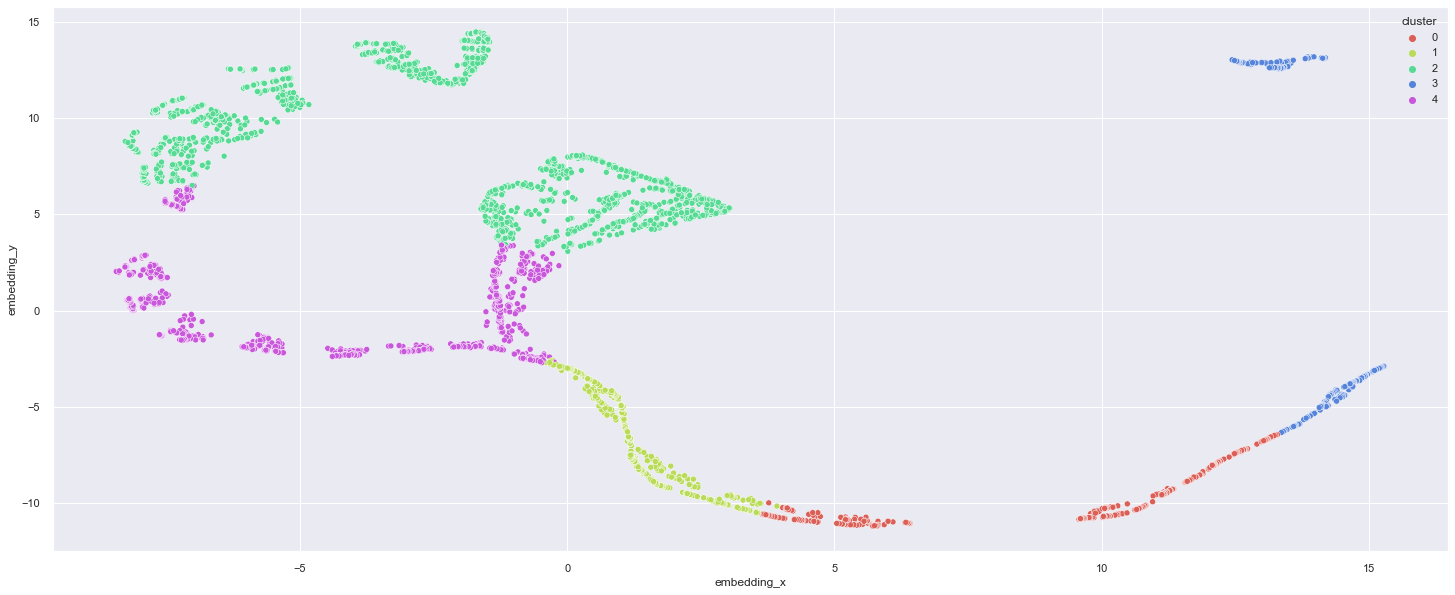

In [53]:
reducer = UMAP(n_neighbors = 80, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
               hue = 'cluster',
               palette = sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())),
               data = df_viz);

## 9.4. Cluster Profile <a id='cluster_profile'></a>

In [54]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_days, how = 'inner', on = 'cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_invoice_no, how = 'inner', on = 'cluster')

# Avg Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_ticket, on = 'cluster', how = 'inner')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,460,10.623557,0.002120,0.643583,0.002460,0.000657
1,1,511,11.801386,0.002761,0.405387,0.005651,0.000728
2,2,1986,45.866051,0.012216,0.045113,0.027854,0.000746
3,3,318,7.344111,0.002264,0.890249,0.001641,0.003715
4,4,1055,24.364896,0.003742,0.184120,0.008327,0.000341


### Cluster 01 (Insider Candidate):

* Number of customers: 6 (0.14% of customers)
* Average recency: 7 days
* Average purchases: 89 purchases
* Average Revenue: $ 182,182.00 dolars

### Cluster 02:

* Number of customers: 31 (0.71% of customers)
* Average recency: 14 days
* Average purchases: 53 purchases
* Average Revenue: $ 40,543.52 dolars

### Cluster 03:

* Number of customers: 4.335 (99.15% of customers)
* Average recency: 92 days
* Average purchases: 5 purchases
* Average Revenue: $ 1,372.57 dolars

# 10.0. Deploy to Production <a id='deploy'></a>